# Data Cleaning and Setup

## CESGA

This notebook marks the beginning of my meteorological forecasting project during my internship at **MeteoGalicia**. My first task was to create a clean and well-structured dataset based on the raw data files provided by my tutors. This step was essential to ensure that the dataset was ready for model training and further analysis.

All data processing and model training were performed remotely on the **CESGA** (*Centro Europeo de Supercomputación de Galicia*) high-performance computing cluster.

To access CESGA, I first established a secure **VPN** connection using the snx command-line utility, which allowed CESGA to identify and authorize my device. Once connected, I used **SSH** to access the cluster and standard Bash commands to navigate directories, manage files, and execute Python scripts.

## Merging our data

Once connected to CESGA facilites, I started polishing the data I had at my disposal. To create a comprehensive dataset, I had to merge multiple files containing hour-by-hour data from a meteorological model alongside observational data collected from various weather stations. Each file represented a different time period or data source, so careful alignment was required to synchronize timestamps and ensure consistency. 

In [ ]:
%%bash
cd GitHub/dataset/
tar -xvzf estaciones.tar.gz
tar -xvzf wrfout.tar.gz

2008 to 2025 .csv files contain hour-by-hour observational data from different stations across Galicia whereas wrfout files contain predictions made by the WRF (Weather Research and Forecasting Model) sorted by hour as well.

In [ ]:
import glob
import pandas as pd

csv_files = sorted(glob.glob("GitHub/dataset/20*.csv"))

df_combined = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)
df_combined.to_csv('Observational_data.csv', index=False)

In [ ]:
import glob
import pandas as pd 
from datetime import datetime, timedelta
import os

csv_files = sorted(glob.glob("GitHub/dataset/wrfout*.csv"))
all_data = []

for file in csv_files:
    # Extract date from filename
    date_str = os.path.basename(file).split('_')[2]  # 'YYYYMMDD' format
    base_datetime = datetime.strptime(date_str, "%Y%m%d")
    
    df = pd.read_csv(file)
    
    # Add hour sequence and datetime column
    df['hour'] = list(range(24)) * (len(df) // 24)
    df['datetime'] = df['hour'].apply(lambda h: base_datetime + timedelta(hours=h))
    
    df.drop(columns='hour', inplace=True)
    all_data.append(df)

# Combine all files
merged_df = pd.concat(all_data, ignore_index=True)
# Save to CSV
merged_df.to_csv("WRF.csv", index=False)

In [2]:
import pandas as pd

obs = pd.read_csv('Observational_data.csv', usecols=['fecha', 'estacion', 'TA'])
obs.rename(columns={'fecha': 'datetime', 'estacion': 'id'}, inplace=True)

wrf = pd.read_csv('WRF.csv')
wrf.drop(columns = ['Time'])
wrf.rename(columns={'estacion': 'id'}, inplace=True)

merged = pd.merge(wrf, obs[['TA','id','datetime']], on=["id", "datetime"], how="inner")
merged.to_csv("DATA.csv", index=False)

## Additional variables

The available data was sufficient to begin developing a model capable of forecasting temperature. However, we identified several missing parameters that could significantly impact the model’s accuracy and decided they were worth adding to our initial dataset. One of these was the percentage of sea surrounding a given location. Although Galicia is not a large region, its weather varies considerably from place to place, which makes our task more challenging. The Atlantic Ocean acts as a thermal reservoir, helping to stabilize coastal temperatures, but its influence decreases as we move inland. We believed that including a parameter representing the sea percentage around each point could improve the model’s accuracy.

In addition to this, we decided to incorporate the latitude, longitude and orography of each location, as well as two variables to represent the hour of the day and the day of the year. Because daily and yearly weather patterns follow periodic cycles, simply providing the model with a numeric hour (e.g., 00:00 to 23:00) or day of the year (1 to 365) would not effectively capture this cyclical nature. To address this, we included two periodic functions: one with a period of 24 hours and another with a period of 365 days, allowing the values to return smoothly to their starting point after a full day or year. This is a common and effective practice in meteorological modeling.

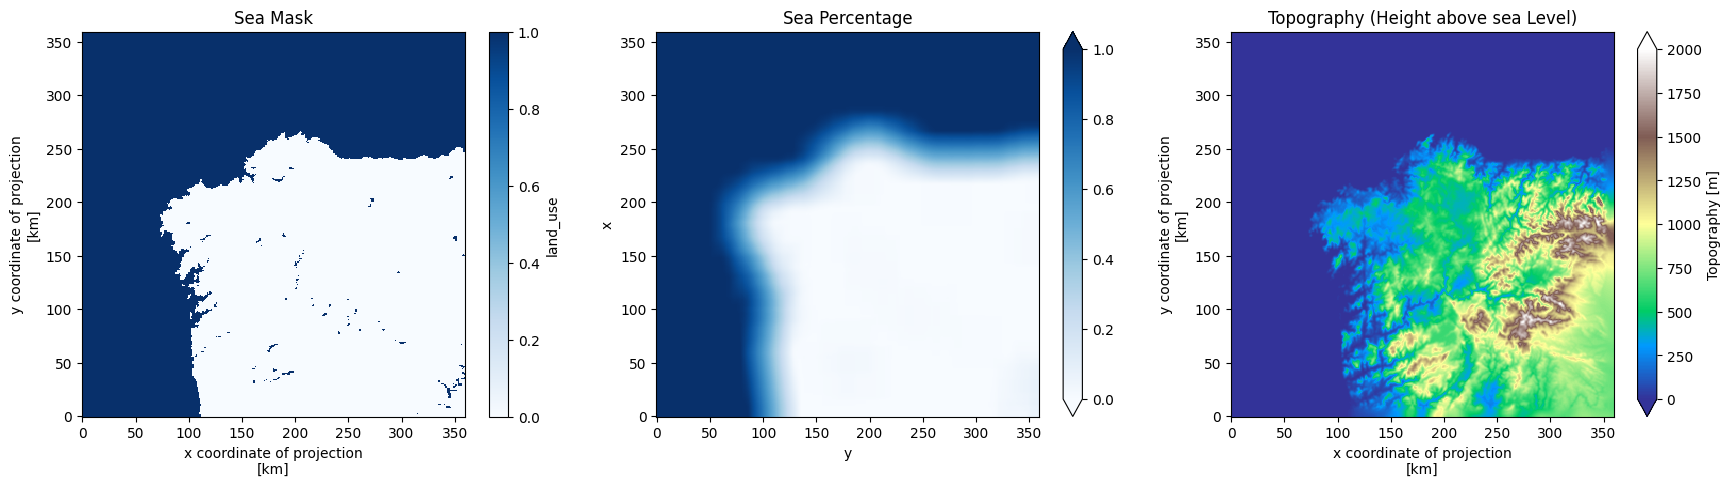

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

url = 'https://mandeo.meteogalicia.es/thredds/dodsC/modelos/WRF_ARW_1KM_HIST_Novo/20250715/wrf_arw_det_history_d02_20250715_0000.nc4' # from MeteoGalicia web database
da = xr.open_dataset(url, engine ='netcdf4')

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize=(21, 5))

# Sea mask plot
sea = (da.isel(time=0)['land_use'] == 17).astype(int)
sea.plot(ax = axes[0], vmin = 0, vmax = 1 ,cmap = 'Blues')
axes[0].set_title('Sea Mask')
# Sea percentage plot
sea_percentage = uniform_filter(sea.astype(float), size=50) # Up to 25km of distance
sea_percentage = xr.DataArray(sea_percentage, dims = ['x','y'])
sea_percentage.plot(ax=axes[1], vmin = 0, vmax = 1, cmap='Blues')
axes[1].set_title('Sea Percent')
# Orography plot
da['topo'].isel(time=0).plot(ax = axes[2], vmin = 0, vmax = 2000, cmap='terrain')
axes[2].set_title('Orography (Height above sea Level)')

plt.subplots_adjust(wspace=0.2)




Above, we have presented three complementary maps characterizing distinct features of the Galician territory. The first map provides a binary mask delineating sea and land tiles. Building on this, the second map represents the local spatial context by calculating the proportion of sea tiles within a moving 25×25 grid window around each location, effectively capturing the degree of marine influence in the immediate surroundings. Finally, the third map illustrates the orographic variability across Galicia, revealing a complex terrain with pronounced mountainous regions inland and comparatively flatter areas along the coastal margin, highlighting the region’s diverse structure.

Now we will add the variables we previously talked about to the existing DataFrame. Incorporating the hour and day variables is straightforward. However, assigning the sea percentage to each station is more involved. The MeteoGalicia dataset provides land use information on a 360x360 grid covering the Galician territory. To estimate the sea percentage at each station, we match each station to the nearest point on this grid. While interpolation would provide a smoother result, it requires well-organized (monotonically increasing) coordinate arrays, but, since the available dataset uses an irregular grid structure, we opted for the nearest-neighbor approach as a reliable alternative.

In [21]:
import pandas as pd
import numpy as np
import xarray as xr
from scipy.ndimage import uniform_filter
from scipy.spatial import cKDTree

# Load sea/land use data from MeteoGalicia
url = 'https://mandeo.meteogalicia.es/thredds/dodsC/modelos/WRF_ARW_1KM_HIST_Novo/20250715/wrf_arw_det_history_d02_20250715_0000.nc4'
da = xr.open_dataset(url, engine='netcdf4')
da = da.isel(time=0)


# Create sea mask
sea = (da['land_use'] == 17).astype(int)
# Smooth to get sea percentage (approx. 25 km radius)
sea_percentage = uniform_filter(sea.astype(float), size=50)
# Wrap into xarray
sea_percent = xr.DataArray(
    sea_percentage,
    dims=da['land_use'].dims,
    coords=da['land_use'].coords,
    name='sea_percent'
)


# Extract 2D lat/lon arrays
lat2d = sea_percent['lat'].values  
lon2d = sea_percent['lon'].values  
# Flatten to (N, 2) array for KDTree
grid_points = np.column_stack((lat2d.ravel(), lon2d.ravel()))
# Build KDTree
tree = cKDTree(grid_points)
# Load stations dataframe 'df' with XLAT/XLONG columns
station_coords = df[['XLAT', 'XLONG']].values
# Query the nearest grid point for each station ignoring the first column (distances)
_, idx = tree.query(station_coords)
# Assign sea percent from flattened sea_percent grid
df['sea_percent'] = sea_percent.values.ravel()[idx]


# We convert the original string datetime to a datetime object
df['datetime'] = pd.to_datetime(df['datetime']) 
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
# Daily periodical features
df['hour_sin'] = np.sin(2*np.pi*df['hour']/24) 
df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
# Yearly periodical features
df['day_sin'] = np.sin(2*np.pi*df['day']/365) 
df['day_cos'] = np.cos(2*np.pi*df['day']/365)


# Save the updated DataFrame
df.to_csv('DATA_v1.csv', index=False)


With our dataset now fully assembled and organized, we can move on to the analysis phase. Before training the neural network model, we will first identify the variables most closely related to temperature. This includes examining correlations between parameters and assessing the overall quality and consistency of the data to ensure it is suitable for training an AI model effectivel